# Function

(1) comparation plots (y: 14 regions, x: DIC/TA/TA-DIC)
- DIC
- TA
- TA-DIC

(2) selected model evaluation metrics:
- bias
- RMSE
- WSS

NOTES: data save as .csv & plots


In [1]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'monospace',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

Text(0.5, 0.98, 'colours assigned')

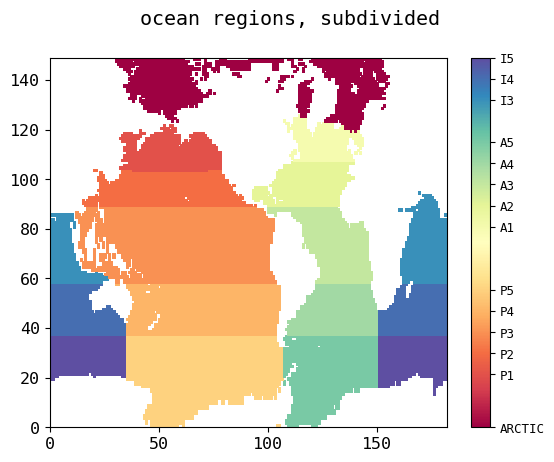

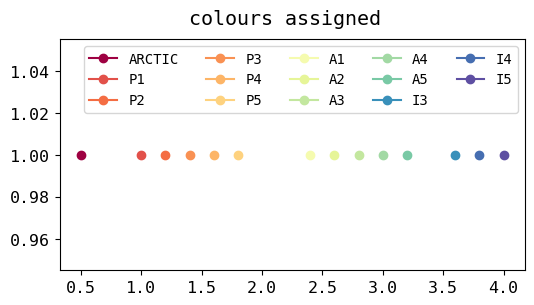

In [2]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan


w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('colours assigned')

In [3]:
mean_masks = np.zeros([len(regs), 149, 182])
for i, reg in enumerate(regs):
    mean_masks[i][maskno == regdict[reg]['number']] = 1

- directory path, prepare for saving plots & data

In [4]:
yrst = 1990
yrend = 2020
modlist = 'TOM12_TJ_GEA0'

In [5]:
import os
import csv

def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)


def save_data_as_csv(data, csv_file_path):
    with open(csv_file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)


# create directory
directory_path = os.path.join("/gpfs/home/gdg21vsa/ModelEvaluation/", modlist)
create_directory(directory_path)

(0) loading data

- GLOBAL DATA: tdat_OBS

In [6]:
df = pd.read_csv('/gpfs/home/mep22dku/scratch/SOZONE/evalOutput/datasets/GLODAPv2.2022_GLOBAL_valid_DICTA_umolL_STITCHED.csv')

df = df[(df.YR >= yrst) & (df.YR <= yrend)]
df = df[df.PRES <= 10]  #surface

df

,Unnamed: 0,YR,MONTH,DIC,ALK,SAL,TEMP,PRES,LAT,LON,Y,X,Z,Zdep,DP,REG,STATION,CRUISE
18739,18739,1990.0,5.0,2104.092014,2400.979613,35.3910,12.0020,10.000,55.61800,-19.97000,114.0,131.0,4.999938,0.0,20149.0,2.4,69.0,669.0
18759,18759,1990.0,5.0,2111.699054,2409.879257,35.4320,12.9060,10.000,52.52800,-20.00000,111.0,131.0,4.999938,0.0,19376.0,2.4,66.0,669.0
18772,18772,1990.0,5.0,2101.615389,2416.452218,35.7550,15.3070,10.000,47.05700,-19.90000,107.0,131.0,4.999938,0.0,18427.0,2.4,51.0,669.0
18776,18776,1990.0,5.0,2140.324492,2429.130210,35.9650,15.3510,10.000,38.99800,-20.00300,102.0,131.0,4.999938,0.0,15513.0,2.6,41.0,669.0
18798,18798,1990.0,5.0,2115.226922,2423.152049,35.9030,14.7890,10.000,41.00300,-19.99800,103.0,131.0,4.999938,0.0,16507.0,2.6,43.0,669.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388940,388940,2020.0,7.0,2075.801888,2313.458578,33.6795,8.6635,3.246,55.25276,-53.99350,114.0,115.0,4.999938,0.0,20008.0,2.4,66.0,4005.0
388943,388943,2020.0,7.0,2065.402333,2255.366830,32.2141,2.7871,9.934,54.95612,-54.28842,114.0,115.0,4.999938,0.0,19917.0,2.4,57.0,4005.0
388951,388951,2020.0,7.0,2030.767627,2250.484647,32.3338,7.3996,2.772,55.09360,-54.11322,114.0,115.0,4.999938,0.0,19976.0,2.4,61.0,4005.0
388952,388952,2020.0,7.0,2042.009887,2261.445162,32.5804,4.2822,9.503,55.09420,-54.11396,114.0,115.0,4.999938,0.0,19977.0,2.4,61.0,4005.0


In [7]:

tDIC = np.array(df['DIC'][:])
tALK = np.array(df['ALK'][:])

tYEAR = np.array(df['YR'])
tMONTH = np.array(df['MONTH'])
tY = np.array(df['Y'])
tX = np.array(df['X'])

tREG_new = np.array(tX)


for j in range(len(tY)):
    y = tY[j].astype(int)
    x = tX[j].astype(int)
    tREG_new[j] = maskno[y, x]

print(tREG_new)
# len(tREG_new)

[2.4 2.4 2.4 ... 2.4 2.4 2.4]


In [8]:
# for model match
t0 = np.zeros_like(tDIC)

td = {}
td = {'YEAR': tYEAR,'MONTH': tMONTH, 'y': tY, 'x': tX ,'obs_DIC':  tDIC, 'obs_TA':tALK, 'REG': tREG_new, 
      'REG_Group': tREG_new}
tdat_OBS = pd.DataFrame(data=td)

tdat_OBS = tdat_OBS[(tdat_OBS.obs_DIC>-999) & (tdat_OBS.obs_TA>-999) 
                    & (tdat_OBS.obs_DIC != 0) & (tdat_OBS.obs_TA != 0)]
tdat_OBS

,YEAR,MONTH,y,x,obs_DIC,obs_TA,REG,REG_Group
0,1990.0,5.0,114.0,131.0,2104.092014,2400.979613,2.4,2.4
1,1990.0,5.0,111.0,131.0,2111.699054,2409.879257,2.4,2.4
2,1990.0,5.0,107.0,131.0,2101.615389,2416.452218,2.4,2.4
3,1990.0,5.0,102.0,131.0,2140.324492,2429.130210,2.6,2.6
4,1990.0,5.0,103.0,131.0,2115.226922,2423.152049,2.6,2.6
...,...,...,...,...,...,...,...,...
19683,2020.0,7.0,114.0,115.0,2075.801888,2313.458578,2.4,2.4
19684,2020.0,7.0,114.0,115.0,2065.402333,2255.366830,2.4,2.4
19685,2020.0,7.0,114.0,115.0,2030.767627,2250.484647,2.4,2.4
19686,2020.0,7.0,114.0,115.0,2042.009887,2261.445162,2.4,2.4


- MODEL DATA: tdat_MOD_DIC, tdat_MOD_TA

In [9]:
import glob

def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

baseDir = '/gpfs/data/greenocean/software/runs/'
depth = 0
dtype = 'ptrc'

modnam = modlist
tylist = make_yearlist(yrst, yrend, dtype, modnam, baseDir)
tdat_MOD = xr.open_mfdataset(tylist)

tdat_MOD_0 = tdat_MOD.isel(deptht= depth)
tdat_MOD_0

<xarray.Dataset>
Dimensions:               (y: 149, x: 182, time_counter: 372, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    deptht                float32 5.0
    time_centered         (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter          (time_counter) object 1990-01-16 12:00:00 ... 2020-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/34)
    deptht_bounds         (time_counter, axis_nbounds) float32 dask.array<chunksize=(12, 2), meta=np.ndarray>
    Alkalini              (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    O2                    (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    DIC                   (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    ...                    ...
    BSi                   (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    GON                   (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    C11                   (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    B14B                  (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    C14B                  (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    D14B                  (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
Attributes:
    name:         ORCA2_1m_19900101_19901231
    description:  planktom sms variables
    title:        planktom sms variables
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2023-Jun-19 23:39:22 BST

In [10]:
# save DIC as Dataframe
tdat_MOD_DIC = tdat_MOD_0['DIC'].to_dataframe(dim_order=None)
tdat_MOD_DIC = tdat_MOD_DIC.loc[:, ['DIC']]     #only keep DIC and multiple index
tdat_MOD_DIC = tdat_MOD_DIC[(tdat_MOD_DIC[['DIC']] != 0).all(axis=1)]
tdat_MOD_DIC = tdat_MOD_DIC.dropna()

tdat_MOD_DIC = tdat_MOD_DIC.reset_index()

tdat_MOD_DIC['YEAR'] = tdat_MOD_DIC['time_counter'].apply(lambda x: x.year)
tdat_MOD_DIC['MONTH'] = tdat_MOD_DIC['time_counter'].apply(lambda x: x.month)

tdat_MOD_DIC


,time_counter,y,x,DIC,YEAR,MONTH
0,1990-01-16 12:00:00,1,50,0.002237,1990,1
1,1990-01-16 12:00:00,1,51,0.002230,1990,1
2,1990-01-16 12:00:00,1,52,0.002218,1990,1
3,1990-01-16 12:00:00,1,53,0.002202,1990,1
4,1990-01-16 12:00:00,1,54,0.002186,1990,1
...,...,...,...,...,...,...
6189331,2020-12-16 12:00:00,148,147,0.002138,2020,12
6189332,2020-12-16 12:00:00,148,148,0.002139,2020,12
6189333,2020-12-16 12:00:00,148,149,0.002154,2020,12
6189334,2020-12-16 12:00:00,148,150,0.002199,2020,12


In [11]:
# save TA as Dataframe
tdat_MOD_TA = tdat_MOD_0['Alkalini'].to_dataframe(dim_order=None)
tdat_MOD_TA = tdat_MOD_TA.loc[:, ['Alkalini']]     #only keep TA and multiple index
tdat_MOD_TA = tdat_MOD_TA[(tdat_MOD_TA[['Alkalini']] != 0).all(axis=1)]
tdat_MOD_TA = tdat_MOD_TA.dropna()

tdat_MOD_TA = tdat_MOD_TA.reset_index()

tdat_MOD_TA['YEAR'] = tdat_MOD_TA['time_counter'].apply(lambda x: x.year)
tdat_MOD_TA['MONTH'] = tdat_MOD_TA['time_counter'].apply(lambda x: x.month)

tdat_MOD_TA

,time_counter,y,x,Alkalini,YEAR,MONTH
0,1990-01-16 12:00:00,1,50,0.002373,1990,1
1,1990-01-16 12:00:00,1,51,0.002363,1990,1
2,1990-01-16 12:00:00,1,52,0.002349,1990,1
3,1990-01-16 12:00:00,1,53,0.002330,1990,1
4,1990-01-16 12:00:00,1,54,0.002310,1990,1
...,...,...,...,...,...,...
6189331,2020-12-16 12:00:00,148,147,0.002209,2020,12
6189332,2020-12-16 12:00:00,148,148,0.002207,2020,12
6189333,2020-12-16 12:00:00,148,149,0.002218,2020,12
6189334,2020-12-16 12:00:00,148,150,0.002257,2020,12


MATCH DATA: tdat_merge_molDIC, tdat_merge_molTA (unit change --> umol/L)

In [12]:
tdat_merge_modDIC = pd.merge(tdat_MOD_DIC, tdat_OBS, on=['YEAR', 'MONTH', 'y', 'x'])
tdat_merge_modDIC = tdat_merge_modDIC.loc[:, ['DIC','obs_DIC', 'REG','REG_Group']]
tdat_merge_modDIC['DIC'] = tdat_merge_modDIC['DIC']*1e6
tdat_merge_modDIC

,DIC,obs_DIC,REG,REG_Group
0,2158.428955,2149.727810,2.6,2.6
1,2150.175293,2126.415518,2.6,2.6
2,2146.953857,2121.500249,2.6,2.6
3,2141.251953,2140.324492,2.6,2.6
4,2134.084229,2115.226922,2.6,2.6
...,...,...,...,...
18316,2028.151367,2049.184084,NaN,NaN
18317,2065.827637,2097.471814,NaN,NaN
18318,2065.827637,2094.815110,NaN,NaN
18319,2065.827637,2101.373838,NaN,NaN


In [13]:
tdat_merge_modTA = pd.merge(tdat_MOD_TA, tdat_OBS, on=['YEAR', 'MONTH', 'y', 'x'])
tdat_merge_modTA = tdat_merge_modTA.loc[:, ['Alkalini','obs_TA','REG','REG_Group']]
tdat_merge_modTA['Alkalini'] = tdat_merge_modTA['Alkalini']*1e6
tdat_merge_modTA

,Alkalini,obs_TA,REG,REG_Group
0,2491.530518,2443.455842,2.6,2.6
1,2471.143311,2443.884418,2.6,2.6
2,2462.401611,2450.649000,2.6,2.6
3,2454.704346,2429.130210,2.6,2.6
4,2448.490234,2423.152049,2.6,2.6
...,...,...,...,...
18316,2337.496338,2316.433335,NaN,NaN
18317,2346.829102,2325.908323,NaN,NaN
18318,2346.829102,2326.113552,NaN,NaN
18319,2346.829102,2322.241729,NaN,NaN


MEAN DATA: tdat_fil_mean, tdat_merge_modDIC_mean, tdat_merge_modTA_mean

In [14]:
# GLODAP data
td = {}
td = {'DIC':  tDIC, 'TA':tALK, 'REG': tREG_new, 'REG_Group': tREG_new,}
tdat = pd.DataFrame(data=td)

tdat_fil = tdat[(tdat.DIC>-999) & (tdat.TA>-999) & (tdat.DIC != 0) & (tdat.TA != 0)]

tdat_fil_mean = tdat_fil.groupby(by=["REG_Group"]).mean()
tdat_fil_mean

,DIC,TA,REG
REG_Group,,,
0.5,2009.272792,2162.939725,0.5
1.0,2056.113143,2248.313408,1.0
1.2,2029.729962,2333.155341,1.2
1.4,1994.805573,2324.633457,1.4
1.6,2082.613908,2378.459521,1.6
1.8,2201.402031,2345.347694,1.8
2.4,2130.505763,2352.674924,2.4
2.6,2089.543237,2396.301380,2.6
2.8,2025.046600,2364.825541,2.8


In [15]:
# model DIC
tdat_merge_modDIC_mean = tdat_merge_modDIC.groupby(by=["REG_Group"]).mean()
tdat_merge_modDIC_mean

,DIC,obs_DIC,REG
REG_Group,,,
0.5,2110.632080,2008.334284,0.5
1.0,2051.418945,2057.532878,1.0
1.2,2032.357422,2029.729962,1.2
1.4,2001.742310,1994.805573,1.4
1.6,2096.297607,2082.613908,1.6
1.8,2212.486572,2201.402031,1.8
2.4,2088.195068,2129.358495,2.4
2.6,2161.561768,2089.338601,2.6
2.8,2079.768799,2025.046600,2.8


In [16]:
# model TA
tdat_merge_modTA_mean = tdat_merge_modTA.groupby(by=["REG_Group"]).mean()
tdat_merge_modTA_mean

,Alkalini,obs_TA,REG
REG_Group,,,
0.5,2254.503906,2161.995471,0.5
1.0,2245.487793,2249.453090,1.0
1.2,2373.426758,2333.155341,1.2
1.4,2370.825439,2324.633457,1.4
1.6,2423.574219,2378.459521,1.6
1.8,2353.239990,2345.347694,1.8
2.4,2291.071045,2351.383783,2.4
2.6,2533.249023,2396.131899,2.6
2.8,2471.391357,2364.825541,2.8


(1) PLOTS: comparation plots

In [17]:
# marker = ['o','o','o','o','o']
color = ['r','m','c','y','g']
s = 70

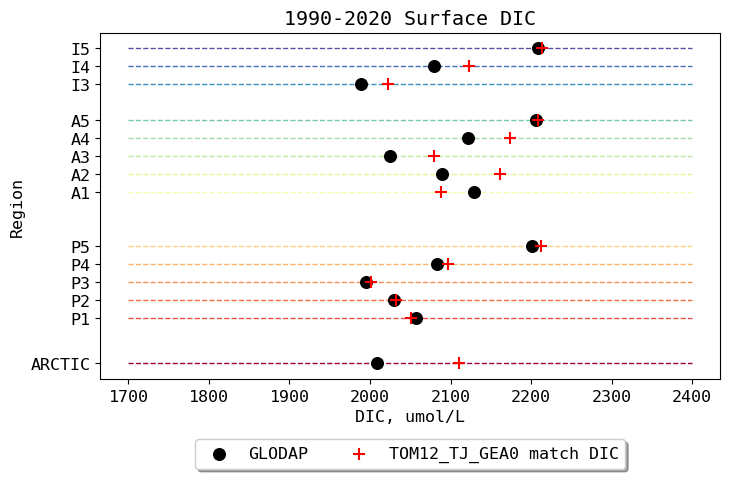

In [18]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)

# #GLODAP
# plt.scatter(tdat_fil_mean['DIC'],tdat_fil_mean['REG'] ,marker = 'o', s=s,label = 'GLODAP',color='k', zorder=4)

#GLODAP --> after match
plt.scatter(tdat_merge_modDIC_mean['obs_DIC'],tdat_merge_modDIC_mean['REG'] ,
            marker = 'o', s=s,label = 'GLODAP',color='k', zorder=4)

# match model data
plt.scatter(tdat_merge_modDIC_mean['DIC'],tdat_merge_modDIC_mean['REG'],
            marker = '+', s=s,label = f'{modlist} match DIC',color='r', zorder=5)

#background region line
xmin = 1700
xmax = 2400
y = (0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.4, 2.6, 2.8, 3, 3.2, 3.6, 3.8, 4)
labels = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.hlines(y=regdict[regs[i]]['number'], 
               xmin=xmin, 
               xmax=xmax, 
                colors = rgba, linestyles='--', lw=1, zorder=-4)

    # plt.plot(xmin,regdict[regs[i]]['number'], 
    #          color = rgba, label = regs[i],zorder=-3)        # line legend
    regdict[regs[i]]['colour'] = rgba


# y label
plt.yticks(y, labels) #rotation='vertical')


# legend position
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3) # Put a legend below current axis

# ax.set_facecolor("black")

# plt.title(f'{yrst}-{yrend} Surface TA vs. DIC, TOM12_TJ_GEA0')
plt.xlabel('DIC, umol/L')
plt.ylabel('Region')
plt.title(f'{yrst}-{yrend} Surface DIC')

image_file_path = os.path.join(directory_path, f'{yrst}-{yrend}Surface_DIC.png')
plt.savefig(image_file_path)

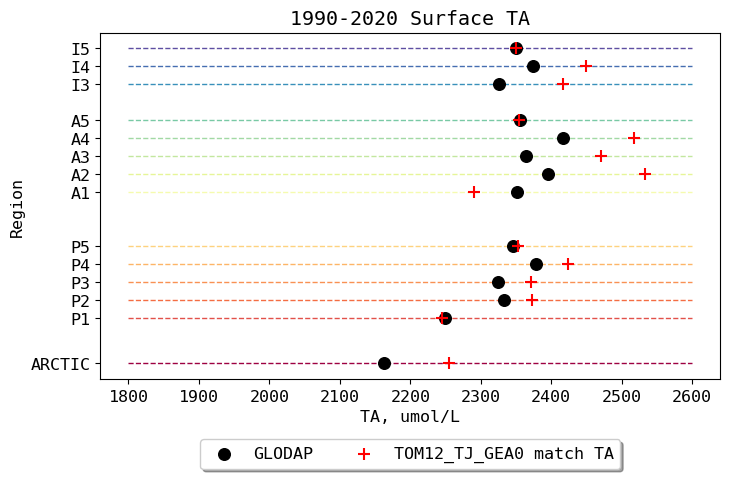

In [19]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)


# # GLODAP
# plt.scatter(tdat_fil_mean['TA'],tdat_fil_mean['REG'] ,marker = 'o', s=s,label = 'GLODAP',color='k', zorder=4)

#GLODAP --> match
plt.scatter(tdat_merge_modTA_mean['obs_TA'],tdat_merge_modTA_mean['REG'] ,
            marker = 'o', s=s,label = 'GLODAP',color='k', zorder=4)

# match
plt.scatter(tdat_merge_modTA_mean['Alkalini'],tdat_merge_modTA_mean['REG'] ,
            marker = '+', s=s,label = f'{modlist} match TA',color='r', zorder=5)

#background region line
xmin = 1800
xmax = 2600
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.hlines(y=regdict[regs[i]]['number'], 
               xmin=xmin, 
               xmax=xmax, 
                colors = rgba, linestyles='--', lw=1, zorder=-5)
    # plt.plot(xmin,regdict[regs[i]]['number'], 
    #          color = rgba, label = regs[i],zorder=-4)        # for legend
    regdict[regs[i]]['colour'] = rgba

# y label
plt.yticks(y, labels) #rotation='vertical')

# legend position
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3) # Put a legend below current axis


plt.xlabel('TA, umol/L')
plt.ylabel('Region')
plt.title(f'{yrst}-{yrend} Surface TA')

image_file_path = os.path.join(directory_path, f'{yrst}-{yrend}Surface_TA.png')
plt.savefig(image_file_path)

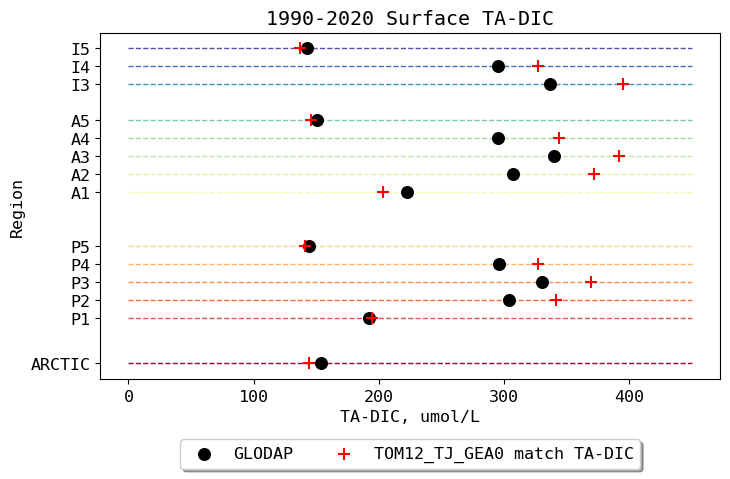

In [20]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)


# #GLODAP
# plt.scatter(tdat_fil_mean['TA'] - tdat_fil_mean['DIC'],
#             tdat_fil_mean['REG'] ,marker = 'o',s=s, label = 'GLODAP',color='k', zorder=4)

# GLODAP --> match
plt.scatter(tdat_merge_modTA_mean['obs_TA']-tdat_merge_modDIC_mean['obs_DIC'],
            tdat_merge_modTA_mean['REG'] ,marker = 'o',s=s, label = 'GLODAP',color='k', zorder=4)


# match
plt.scatter((tdat_merge_modTA_mean['Alkalini']-tdat_merge_modDIC_mean['DIC']),
            tdat_merge_modTA_mean['REG'] ,marker = '+', s=s,label = f'{modlist} match TA-DIC',color='r', zorder=5)

#background region line
xmin = 0
xmax = 450
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.hlines(y=regdict[regs[i]]['number'], 
               xmin=xmin, 
               xmax=xmax, 
                colors = rgba, linestyles='--', lw=1, zorder=-5)
    # plt.plot(xmin,regdict[regs[i]]['number'], 
    #          color = rgba, label = regs[i],zorder=-4)        # for legend
    regdict[regs[i]]['colour'] = rgba

# y label
plt.yticks(y, labels) #rotation='vertical')

# legend position
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3) # Put a legend below current axis


plt.xlabel('TA-DIC, umol/L')
plt.ylabel('Region')
plt.title(f'{yrst}-{yrend} Surface TA-DIC')

image_file_path = os.path.join(directory_path, f'{yrst}-{yrend}Surface_TA-DIC.png')
plt.savefig(image_file_path)

(2) DATA: selected model evaluation metrics

In [21]:
def bias_box(obs,mod):
    bias = (-np.mean(obs) + np.mean(mod))
    return bias

def RMSE_box(obs,mod):
    RMSE = (np.sqrt(np.sum((mod - obs)**2) /len(obs)))
    return RMSE

def WSS_box(obs,mod):
    xbar = np.mean(obs)
    WSS = (1-(np.sum((mod - obs)**2)  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar))**2)))
    return WSS

# EVALUATION METRICS & SAVE .csv

# Global metrics calculate

In [22]:
all_DIC_nonan = tdat_merge_modDIC.dropna()
all_DIC_nonan
all_TA_nonan = tdat_merge_modTA.dropna()
all_TA_nonan

all_TADIC_nonan = pd.concat([all_TA_nonan, all_DIC_nonan], axis=1)
all_TADIC_nonan = all_TADIC_nonan.iloc[:, :-2]
all_TADIC_nonan['mod_TA-DIC'] = all_TADIC_nonan['Alkalini']-all_TADIC_nonan['DIC']
all_TADIC_nonan['obs_TA-DIC'] = all_TADIC_nonan['obs_TA']-all_TADIC_nonan['obs_DIC']
all_TADIC_nonan = all_TADIC_nonan.loc[:, ['mod_TA-DIC','obs_TA-DIC','REG','REG_Group']]
all_TADIC_nonan

,mod_TA-DIC,obs_TA-DIC,REG,REG_Group
0,333.101562,293.728032,2.6,2.6
1,320.968018,317.468900,2.6,2.6
2,315.447754,329.148751,2.6,2.6
3,313.452393,288.805718,2.6,2.6
4,314.406006,307.925127,2.6,2.6
...,...,...,...,...
18307,360.721680,322.654569,1.2,1.2
18308,360.721680,325.320057,1.2,1.2
18309,359.588745,322.339731,1.2,1.2
18310,359.588745,314.798756,1.2,1.2


In [23]:
bias_DIC = bias_box(all_DIC_nonan['obs_DIC'].values, all_DIC_nonan['DIC'].values)
RMSE_DIC = RMSE_box(all_DIC_nonan['obs_DIC'].values, all_DIC_nonan['DIC'].values)
WSS_DIC = WSS_box(all_DIC_nonan['obs_DIC'].values, all_DIC_nonan['DIC'].values)

bias_TA = bias_box(all_TA_nonan['obs_TA'].values, all_TA_nonan['Alkalini'].values)
RMSE_TA = RMSE_box(all_TA_nonan['obs_TA'].values, all_TA_nonan['Alkalini'].values)
WSS_TA = WSS_box(all_TA_nonan['obs_TA'].values, all_TA_nonan['Alkalini'].values)

bias_TADIC = bias_box(all_TADIC_nonan['obs_TA-DIC'].values, all_TADIC_nonan['mod_TA-DIC'].values)
RMSE_TADIC = RMSE_box(all_TADIC_nonan['obs_TA-DIC'].values, all_TADIC_nonan['mod_TA-DIC'].values)
WSS_TADIC = WSS_box(all_TADIC_nonan['obs_TA-DIC'].values, all_TADIC_nonan['mod_TA-DIC'].values)

result_global = [
    {'evaluation_metrics':'bias' ,'DIC': bias_DIC, 'TA': bias_TA, 'TA-DIC': bias_TADIC}, 
    {'evaluation_metrics':'RMSE_DIC' ,'DIC': RMSE_DIC, 'TA': RMSE_TA, 'TA-DIC': RMSE_TADIC},
    {'evaluation_metrics':'WSS' ,'DIC': WSS_DIC,  'TA': WSS_TA,  'TA-DIC': WSS_TADIC}
]
result_global = pd.DataFrame(result_global)
result_global

,evaluation_metrics,DIC,TA,TA-DIC
0,bias,32.542829,53.218844,20.676228
1,RMSE_DIC,96.177339,116.162919,50.293242
2,WSS,0.687978,0.742490,0.931728


    - organise save data

In [24]:
data_global = pd.concat([all_TA_nonan, all_DIC_nonan], axis=1)
data_global = data_global.iloc[:, :-2]
data_global = data_global.loc[:, ['REG','Alkalini','obs_TA','DIC','obs_DIC']]
savedata0_global = pd.concat([data_global, result_global], axis=1)
savedata0_global

csv_file_path = os.path.join(directory_path, f'{yrst}-{yrend}_{modlist}_bias_RMSE_WSS_mean_umolL_global.csv')
savedata0_global.to_csv(csv_file_path, index=False)

# Region metrics calculate

In [25]:
# create a empty DataFrame to save result
result_metric1 = pd.DataFrame(columns=['REG', 'bias_DIC','RMSE_DIC','WSS_DIC'])

result_metric2 = pd.DataFrame(columns=['REG', 'bias_TA','RMSE_TA','WSS_TA',])

result_metric3 = pd.DataFrame(columns=['REG', 'bias_TA-DIC','RMSE_TA-DIC','WSS_TA-DIC'])

#Use a loop to traverse the different REG_Groups, calculate the bias, and add the result to result_metric
for reg_group, group_data in all_DIC_nonan.groupby('REG_Group'):
    obs_values = group_data['obs_DIC'].values
    mod_values = group_data['DIC'].values

    bias_DIC = bias_box(obs_values, mod_values)
    RMSE_DIC = RMSE_box(obs_values, mod_values)
    WSS_DIC = WSS_box(obs_values, mod_values)

    result_metric1 = result_metric1.append({'REG': reg_group, 'bias_DIC': bias_DIC,'RMSE_DIC':RMSE_DIC ,'WSS_DIC':WSS_DIC,}, ignore_index=True)

for reg_group, group_data in all_TA_nonan.groupby('REG_Group'):
    obs_values = group_data['obs_TA'].values
    mod_values = group_data['Alkalini'].values

    bias_TA = bias_box(obs_values, mod_values)
    RMSE_TA = RMSE_box(obs_values, mod_values)
    WSS_TA = WSS_box(obs_values, mod_values)

    result_metric2 = result_metric2.append({'REG': reg_group, 'bias_TA':bias_TA,'RMSE_TA':RMSE_TA,'WSS_TA':WSS_TA}, ignore_index=True)

for reg_group, group_data in all_TADIC_nonan.groupby('REG_Group'):
    obs_values = group_data['obs_TA-DIC'].values
    mod_values = group_data['mod_TA-DIC'].values

    bias_TADIC = bias_box(obs_values, mod_values)
    RMSE_TADIC = RMSE_box(obs_values, mod_values)
    WSS_TADIC = WSS_box(obs_values, mod_values)

    result_metric3 = result_metric3.append({'REG': reg_group, 'bias_TA-DIC':bias_TADIC,'RMSE_TA-DIC':RMSE_TADIC,'WSS_TA-DIC':WSS_TADIC}, ignore_index=True)


result_metric = pd.merge(result_metric1, result_metric2, on='REG')
result_metric = pd.merge(result_metric, result_metric3, on='REG')
result_metric

,REG,bias_DIC,RMSE_DIC,WSS_DIC,bias_TA,RMSE_TA,WSS_TA,bias_TA-DIC,RMSE_TA-DIC,WSS_TA-DIC
0,0.5,102.297552,190.785842,0.458386,92.508435,198.826005,0.522939,-9.789315,51.804347,0.722644
1,1.0,-6.113933,48.687504,0.755550,-3.965053,35.669138,0.873380,2.148651,51.470570,0.746529
2,1.2,2.627460,28.189569,0.825714,40.271416,49.916538,0.628409,37.644048,41.800602,0.773950
3,1.4,6.936736,31.313177,0.926935,46.191982,51.408013,0.756958,39.255185,43.939113,0.689507
4,1.6,13.683700,29.586933,0.910258,45.114697,53.363779,0.699363,31.430967,37.699188,0.886938
5,1.8,11.084542,24.014832,0.857620,7.892296,20.900000,0.774964,-3.192093,16.431833,0.885339
6,2.4,-41.163427,67.685112,0.490612,-60.312982,82.851878,0.570397,-19.149418,35.427477,0.825446
7,2.6,72.223410,94.477311,0.435147,137.117125,166.478315,0.464709,64.894019,82.287628,0.620333
8,2.8,54.722199,108.044858,0.521324,106.565816,143.908211,0.491507,51.843556,55.881241,0.419777
9,3.0,52.095608,61.844126,0.439000,101.032742,111.999704,0.576518,48.937317,55.678572,0.791945


    - organize save data

In [26]:
savedata1_region = pd.merge(result_metric, tdat_merge_modTA_mean, on='REG')
savedata1_region = pd.merge(savedata1_region, tdat_merge_modDIC_mean, on='REG')

csv_file_path = os.path.join(directory_path, f'{yrst}-{yrend}_{modlist}_bias_RMSE_WSS_mean_umolL_region.csv')
savedata1_region.to_csv(csv_file_path, index=False)

savedata1_region

,REG,bias_DIC,RMSE_DIC,WSS_DIC,bias_TA,RMSE_TA,WSS_TA,bias_TA-DIC,RMSE_TA-DIC,WSS_TA-DIC,Alkalini,obs_TA,DIC,obs_DIC
0,0.5,102.297552,190.785842,0.458386,92.508435,198.826005,0.522939,-9.789315,51.804347,0.722644,2254.503906,2161.995471,2110.632080,2008.334284
1,1.0,-6.113933,48.687504,0.755550,-3.965053,35.669138,0.873380,2.148651,51.470570,0.746529,2245.487793,2249.453090,2051.418945,2057.532878
2,1.2,2.627460,28.189569,0.825714,40.271416,49.916538,0.628409,37.644048,41.800602,0.773950,2373.426758,2333.155341,2032.357422,2029.729962
3,1.4,6.936736,31.313177,0.926935,46.191982,51.408013,0.756958,39.255185,43.939113,0.689507,2370.825439,2324.633457,2001.742310,1994.805573
4,1.6,13.683700,29.586933,0.910258,45.114697,53.363779,0.699363,31.430967,37.699188,0.886938,2423.574219,2378.459521,2096.297607,2082.613908
5,2.4,-41.163427,67.685112,0.490612,-60.312982,82.851878,0.570397,-19.149418,35.427477,0.825446,2291.071045,2351.383783,2088.195068,2129.358495
6,2.8,54.722199,108.044858,0.521324,106.565816,143.908211,0.491507,51.843556,55.881241,0.419777,2471.391357,2364.825541,2079.768799,2025.046600
7,3.0,52.095608,61.844126,0.439000,101.032742,111.999704,0.576518,48.937317,55.678572,0.791945,2518.145508,2417.112766,2174.306396,2122.210789
8,3.2,2.560988,32.616904,0.665909,-2.162307,27.295992,0.307814,-4.723448,19.339485,0.796875,2353.939941,2356.102249,2208.411377,2205.850388
9,3.8,42.916623,46.376661,0.825757,75.264287,79.622676,0.473441,32.347847,39.360122,0.896078,2449.571045,2374.306513,2122.372314,2079.455691


=== bia, RMSE, WSS plots (not in function)

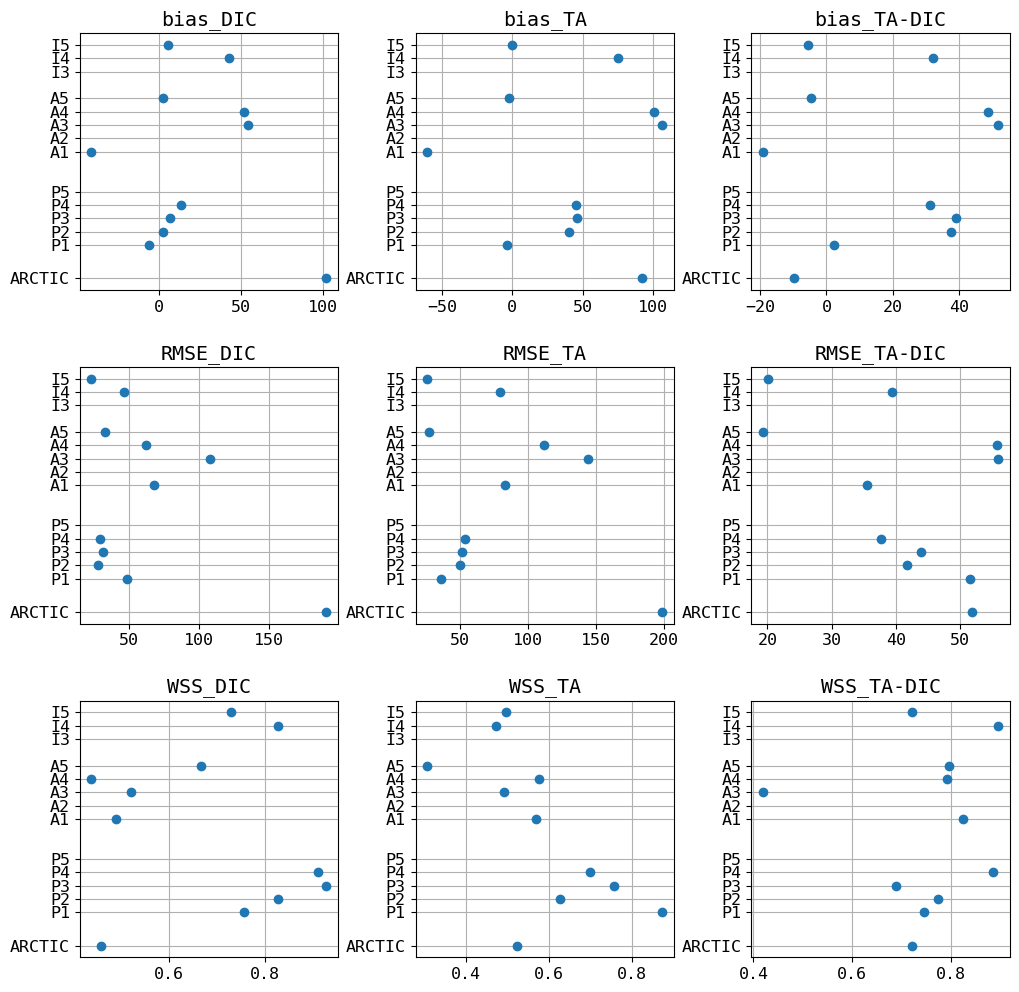

In [41]:
y = (0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.4, 2.6, 2.8, 3, 3.2, 3.6, 3.8, 4)
labels = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

axes[0, 0].plot(savedata1_region['bias_DIC'], savedata1_region['REG'], 'o')
axes[0, 0].set_title('bias_DIC')
axes[0, 0].set_yticks(y, labels)
axes[0, 0].grid(True)

axes[0, 1].plot(savedata1_region['bias_TA'], savedata1_region['REG'], 'o')
axes[0, 1].set_title('bias_TA')
axes[0, 1].set_yticks(y, labels)
axes[0, 1].grid(True)

axes[0, 2].plot(savedata1_region['bias_TA-DIC'], savedata1_region['REG'], 'o')
axes[0, 2].set_title('bias_TA-DIC')
axes[0, 2].set_yticks(y, labels)
axes[0, 2].grid(True)

axes[1, 0].plot(savedata1_region['RMSE_DIC'], savedata1_region['REG'], 'o')
axes[1, 0].set_title('RMSE_DIC')
axes[1, 0].set_yticks(y, labels)
axes[1, 0].grid(True)

axes[1, 1].plot(savedata1_region['RMSE_TA'], savedata1_region['REG'], 'o')
axes[1, 1].set_title('RMSE_TA')
axes[1, 1].set_yticks(y, labels)
axes[1, 1].grid(True)

axes[1, 2].plot(savedata1_region['RMSE_TA-DIC'], savedata1_region['REG'], 'o')
axes[1, 2].set_title('RMSE_TA-DIC')
axes[1, 2].set_yticks(y, labels)
axes[1, 2].grid(True)

axes[2, 0].plot(savedata1_region['WSS_DIC'], savedata1_region['REG'], 'o')
axes[2, 0].set_title('WSS_DIC')
axes[2, 0].set_yticks(y, labels)
axes[2, 0].grid(True)

axes[2, 1].plot(savedata1_region['WSS_TA'], savedata1_region['REG'], 'o')
axes[2, 1].set_title('WSS_TA')
axes[2, 1].set_yticks(y, labels)
axes[2, 1].grid(True)

axes[2, 2].plot(savedata1_region['WSS_TA-DIC'], savedata1_region['REG'], 'o')
axes[2, 2].set_title('WSS_TA-DIC')
axes[2, 2].set_yticks(y, labels)
axes[2, 2].grid(True)

plt.subplots_adjust(hspace=0.3, wspace=0.3)


====

In [27]:
# # merge data
# m_obs_DIC = np.array(tdat_merge_modDIC['obs_DIC'][:])
# m_mod_DIC = np.array(tdat_merge_modDIC['DIC'][:])

# m_obs_TA = np.array(tdat_merge_modTA['obs_TA'][:])
# m_mod_TA = np.array(tdat_merge_modTA['Alkalini'][:])

# mask = ~np.isnan(m_mod_DIC) & ~np.isnan(m_mod_TA)
# bias_DIC = bias_box(m_obs_DIC[mask], m_mod_DIC[mask])
# RMSE_DIC = RMSE_box(m_obs_DIC[mask], m_mod_DIC[mask])
# WSS_DIC = WSS_box(m_obs_DIC[mask], m_mod_DIC[mask])

# bias_TA = bias_box(m_obs_TA[mask],m_mod_TA[mask])
# RMSE_TA = RMSE_box(m_obs_TA[mask],m_mod_TA[mask])
# WSS_TA = WSS_box(m_obs_TA[mask],m_mod_TA[mask])

# bias_TADIC = bias_box(m_obs_TA[mask]- m_obs_DIC[mask], (m_mod_TA[mask]-m_mod_DIC[mask]))
# RMSE_TADIC = RMSE_box(m_obs_TA[mask]- m_obs_DIC[mask], (m_mod_TA[mask]-m_mod_DIC[mask]))
# WSS_TADIC = WSS_box(m_obs_TA[mask]- m_obs_DIC[mask], (m_mod_TA[mask]-m_mod_DIC[mask]))

# data_evaluation = [
#     {'evaluation_metrics':'bias' ,'DIC': bias_DIC, 'TA': bias_TA, 'TA-DIC': bias_TADIC}, 
#     {'evaluation_metrics':'RMSE_DIC' ,'DIC': RMSE_DIC, 'TA': RMSE_TA, 'TA-DIC': RMSE_TADIC},
#     {'evaluation_metrics':'WSS' ,'DIC': WSS_DIC,  'TA': WSS_TA,  'TA-DIC': WSS_TADIC}
# ]
# data_evaluation = pd.DataFrame(data_evaluation)